Import Packages

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score

Loading csv year by year

In [ ]:
df1 = pd.read_csv('C:/Users/test/Desktop/L/LoanStats_2007-2011.csv')
df1['year'] = 2011
df2 = pd.read_csv('C:/Users/test/Desktop/L/LoanStats_2012-2013.csv')
df2['year'] = 2013
df3 = pd.read_csv('C:/Users/test/Desktop/L/LoanStats_2014.csv')
df3['year'] = 2014
df4 = pd.read_csv('C:/Users/test/Desktop/L/LoanStats_2015.csv')
df4['year'] = 2015
df5 = pd.read_csv('C:/Users/test/Desktop/L/LoanStats_2016.csv')
df5['year'] = 2016
df6 = pd.read_csv('C:/Users/test/Desktop/L/LoanStats_2017.csv')
df6['year'] = 2017

Data info

In [7]:
df = pd.concat([df1, df2, df3, df4, df5, df6])
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1646308 entries, 0 to 411706
Columns: 146 entries, id to year
dtypes: float64(96), int64(3), object(47)
memory usage: 1.8+ GB


Filer columns and release memory

In [8]:
#filter df with target cols
data_df = df[['loan_status','annual_inc', 'emp_length', 'inq_last_6mths', 'dti', 'delinq_2yrs', 'purpose', 'loan_amnt', 'term', 'grade', 'total_pymnt', 'total_rec_prncp', 'recoveries', 'year']]

#release memory
del df 

Reset datatype and create dummy variables

In [9]:
#filter loan_status
data_df = data_df[(data_df['loan_status'] == 'Charged Off') | (data_df['loan_status'] == 'Fully Paid') | (data_df['loan_status'] == 'Default')]

#annual_inc to float
data_df['annual_inc'] = data_df['annual_inc'].astype('float64')

#cleaning unknow variable 'Jan-97' in delinq_2yrs and changing delinq_2yrs to float
data_df.drop(data_df[data_df['delinq_2yrs'] == 'Jan-97'].index, axis=0, inplace=True)
data_df['delinq_2yrs'] = data_df['delinq_2yrs'].astype('float64')

#string operation for emp_length
data_df['emp_length'] = data_df['emp_length'].str.replace('years', '')
data_df['emp_length'] = data_df['emp_length'].str.replace('year', '')
data_df['emp_length'] = data_df['emp_length'].str.replace('+', '')
data_df['emp_length'] = data_df['emp_length'].str.replace('< 1', '0')
data_df['emp_length'] = data_df['emp_length'].astype('float64')

#getting dummies for loan_status
data_df['loan_status'] = data_df['loan_status'].str.replace('Charged Off', '1')
data_df['loan_status'] = data_df['loan_status'].str.replace('Default', '1')
data_df['loan_status'] = data_df['loan_status'].str.replace('Fully Paid', '0')
data_df['loan_status'] = data_df['loan_status'].astype('float64')

#getting dummies for purpose
data_df.loc[data_df['purpose'] != 'debt_consolidation', 'purpose'] = 0
data_df.loc[data_df['purpose'] == 'debt_consolidation', 'purpose'] = 1
data_df['purpose'] = data_df['purpose'].astype('float64')

#string operation for term
data_df['term'] = data_df['term'].str.replace('months', '')
data_df['term'] = data_df['term'].astype('int64')

#create grade scored dummies
data_df['grade'] = data_df['grade'].str.replace('A', '1')
data_df['grade'] = data_df['grade'].str.replace('B', '2')
data_df['grade'] = data_df['grade'].str.replace('C', '3')
data_df['grade'] = data_df['grade'].str.replace('D', '4')
data_df['grade'] = data_df['grade'].str.replace('E', '5')
data_df['grade'] = data_df['grade'].str.replace('F', '6')
data_df['grade'] = data_df['grade'].str.replace('G', '7')
data_df['grade'] = data_df['grade'].astype('int64')

C:\Users\test\AppData\Local\Temp/ipykernel_20744/3275308151.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_df['emp_length'] = data_df['emp_length'].str.replace('+', '')


In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916567 entries, 0 to 411701
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   loan_status      916567 non-null  float64
 1   annual_inc       916567 non-null  float64
 2   emp_length       916567 non-null  float64
 3   inq_last_6mths   916566 non-null  float64
 4   dti              916567 non-null  float64
 5   delinq_2yrs      916567 non-null  float64
 6   purpose          916567 non-null  float64
 7   loan_amnt        916567 non-null  int64  
 8   term             916567 non-null  int64  
 9   grade            916567 non-null  int64  
 10  total_pymnt      916567 non-null  float64
 11  total_rec_prncp  916567 non-null  float64
 12  recoveries       916567 non-null  float64
 13  year             916567 non-null  int64  
dtypes: float64(10), int64(4)
memory usage: 104.9 MB


Drop na and count percentage for each time span

In [13]:
#drop na; one row
data_df = data_df.dropna()

data_df = data_df.set_index('year', drop=False,)

#find percentage for each year
years_list = [2011, 2013, 2014, 2015, 2016, 2017]
total = data_df['loan_status'].count()
for year in years_list:
    c = data_df.loc[year]['loan_status'].count()
    percent = str(round((c/total)*100, 2))
    print(str(year) + ' percentage:' + percent + '%\n')


#set year col as index
data_df = data_df.reset_index(drop=True)

2011 percentage:2.72%

2013 percentage:19.16%

2014 percentage:22.09%

2015 percentage:29.45%

2016 percentage:19.14%

2017 percentage:7.43%



Subsetting X and y for model training

In [14]:
#subsetting X, y
y = data_df['loan_status']
X = data_df.loc[:, (data_df.columns!='loan_status') & (data_df.columns!='recoveries') & (data_df.columns!='total_rec_prncp') & (data_df.columns!='total_pymnt')]


Function for original model  
Model: RandomForest  
Resample method: SMOTE  

In [15]:
def clf_original():
    #split train, test dataset
    X_train, X_test, y_train, y_test  =\
        train_test_split(X, y, test_size=0.25, shuffle = False)
        
    #data resample, using SMOTE
    X_re, y_re = SMOTE(random_state=1111).fit_resample(X_train, y_train)  
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=18, random_state=1111, criterion='entropy')

    clf.fit(X_re, y_re)
    train_predictions = clf.predict(X_re)
    test_predictions = clf.predict(X_test)

    cm = confusion_matrix(y_test, test_predictions)
    print(accuracy_score(y_re, train_predictions))
    print(accuracy_score(y_test, test_predictions))
    print(precision_score(y_test, test_predictions))
    print(cm)
    sorted_idx = clf.feature_importances_.argsort()
    plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])

    plot_confusion_matrix(clf, X_test, y_test)  
    plt.show()

Model validation using K-fold  
K=5

In [16]:
def shuffle_kfold():
    #shuffle dataset and run K-fold
    in_dic = {0:[0,146649],1:[146650,183313],2:[183314,329964],3:[329965,366628],4:[366629,513279],5:[513280,5499943],6:[549944,696594],7:[696595,733258],8:[733259,879908],9:[879909,916565]}

    avg_precison = []
    avg_recall = []
    avg_accuracy = []
    train_index = 0
    test_index = 1
    data_df_1 = data_df.sample(frac=1)
    data_df_1 = data_df_1.reset_index(drop=True)
    y_1 = data_df['loan_status']
    X_1 = data_df.loc[:, (data_df.columns!='loan_status') & (data_df.columns!='recoveries') & (data_df.columns!='total_rec_prncp') & (data_df.columns!='total_pymnt')]
    for i in range(5):
        train = in_dic[train_index]
        test = in_dic[test_index]
        X_train = X_1[train[0]:train[1]]
        X_test = X_1[test[0]:test[1]]
        y_train = y_1[train[0]:train[1]]
        y_test = y_1[test[0]:test[1]]
        
        X_re, y_re = SMOTE(random_state=1111).fit_resample(X_train, y_train)  
        
        clf = RandomForestClassifier(n_estimators=100, max_depth=18, random_state=1111, criterion='entropy')

        clf.fit(X_re, y_re)
        train_predictions = clf.predict(X_re)
        test_predictions = clf.predict(X_test)
        
        train_accuracy = round(accuracy_score(y_re, train_predictions), 3)
        test_accuracy = round(accuracy_score(y_test, test_predictions), 3)
        avg_accuracy.append(test_accuracy )
        print(train_accuracy)
        print(test_accuracy)
        

        avg_precison.append(round(precision_score(y_test, test_predictions), 3))
        avg_recall.append(round(recall_score(y_test, test_predictions), 3))
        plot_confusion_matrix(clf, X_test, y_test)  
        plt.show()
        
        train_index += 2
        test_index += 2
    avg_precision_score = sum(avg_precison) / len(avg_precison)
    avg_recall_score = sum(avg_recall) / len(avg_recall)
    print(avg_precision_score, avg_recall_score)
    
    return(avg_precison, avg_recall, avg_accuracy)    

Model validation using TimeSplit

In [17]:
def time_split():
    avg_precison = []
    avg_recall = []
    avg_accuracy = []
    years_list_1 = [2013, 2014, 2015, 2016, 2017]
    
    for year in years_list_1:
        #filter year for train data
        train_data = data_df[data_df['year'] == year]
        #subset X, y dataset
        X_train = train_data.loc[:, (data_df.columns!='loan_status') & (data_df.columns!='recoveries') & (data_df.columns!='total_rec_prncp') & (data_df.columns!='total_pymnt') & (data_df.columns!='year')]
        y_train = train_data['loan_status']
        #count total row for training data
        row_count = y_train.count()
        #set test data size: round to interger
        test_count = int(row_count*0.2)
        
        X_re, y_re = SMOTE(random_state=1111).fit_resample(X_train, y_train)
        
        #filter year for test data
        if year<2017:
            test_data = data_df[data_df['year'] == year+1]
            #subset X, y dataset
            X_test = test_data.loc[:, (data_df.columns!='loan_status') & (data_df.columns!='recoveries') & (data_df.columns!='total_rec_prncp') & (data_df.columns!='total_pymnt') & (data_df.columns!='year')][0:test_count]
            y_test = test_data['loan_status'][0:test_count]                            
        else:
            break
        
        clf = RandomForestClassifier(n_estimators=100, max_depth=18, random_state=1111, criterion='entropy')
        
        clf.fit(X_re, y_re)
        train_predictions = clf.predict(X_re)
        test_predictions = clf.predict(X_test)
        
        train_accuracy = round(accuracy_score(y_re, train_predictions), 3)
        test_accuracy = round(accuracy_score(y_test, test_predictions), 3)
        avg_accuracy.append(test_accuracy )
        print(train_accuracy)
        print(test_accuracy)
        
        
        avg_precison.append(round(precision_score(y_test, test_predictions), 3))
        avg_recall.append(round(recall_score(y_test, test_predictions), 3))
        plot_confusion_matrix(clf, X_test, y_test)  
        plt.show()
        avg_precision_score = sum(avg_precison) / len(avg_precison)
        avg_recall_score = sum(avg_recall) / len(avg_recall)
        print(avg_precision_score, avg_recall_score)
        
    return(avg_precison, avg_recall, avg_accuracy)


0.8605338295152282
0.7709978965008597
0.4496039532010755
[[170481   7574]
 [ 44900   6187]]


c:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


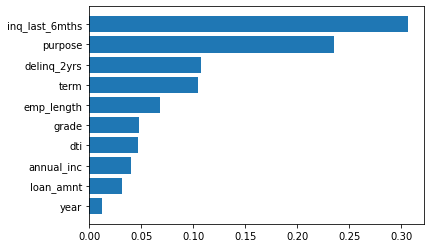

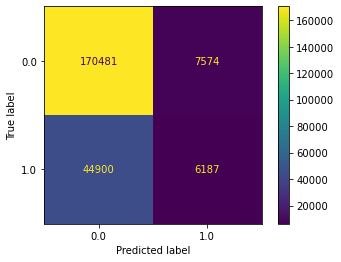

In [20]:
clf_original()

0.908
0.833


c:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


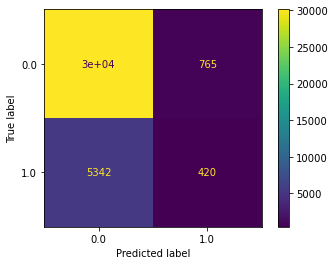

0.902
0.81


c:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


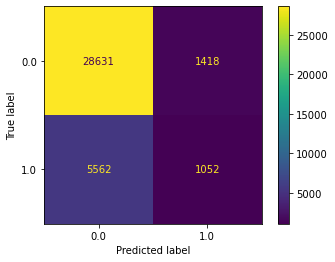

0.888
0.77


c:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


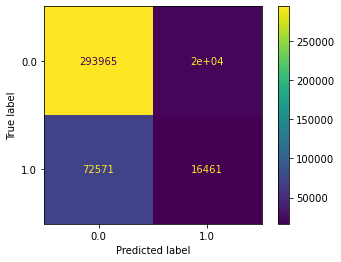

0.889
0.742


c:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


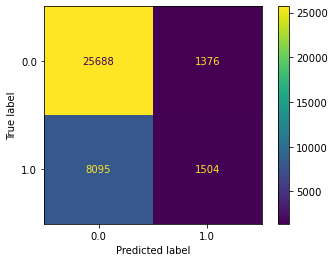

0.878
0.858


c:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


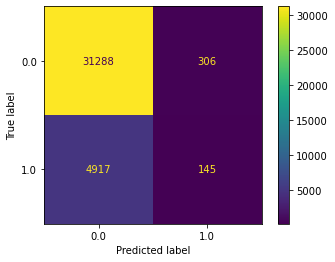

0.4144 0.1206


([0.354, 0.426, 0.448, 0.522, 0.322],
 [0.073, 0.159, 0.185, 0.157, 0.029],
 [0.833, 0.81, 0.77, 0.742, 0.858])

In [21]:
shuffle_kfold()

0.9
0.811


c:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


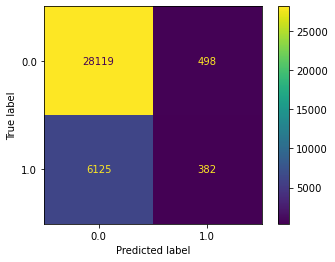

0.434 0.059
0.895
0.738


c:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


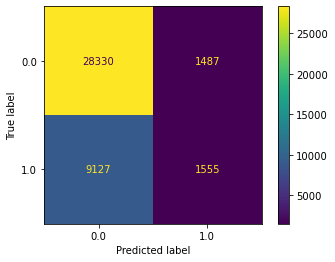

0.47250000000000003 0.1025
0.864
0.738


c:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


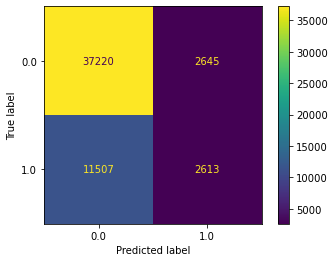

0.48066666666666674 0.13
0.87
0.798


c:\Users\test\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


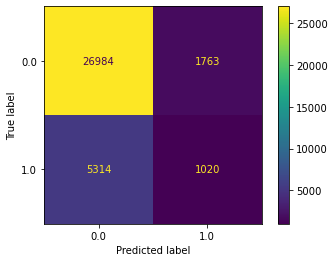

0.45225000000000004 0.13775


([0.434, 0.511, 0.497, 0.367],
 [0.059, 0.146, 0.185, 0.161],
 [0.811, 0.738, 0.738, 0.798])

In [19]:
time_split()